# Proyecto Final


## 1. Introducción
Las transacciones fraudulentas son una problemática que ha crecido a la par de la popularidad de las ventas y plataformas de pagos en línea. A pesar de esto, los fraudes son una minoría en comparación con la cantidad total de transacciones que se realizan. Esto ha llevado a los investigadores a explorar diversas técnicas de machine learning, en combinación con técnicas de resampleo y generación de datos sintéticos para implementar modelos que capturen los patrones de los datos fraudulentos. En el presente proyecto desarrollamos una metodología que utiliza dos técnicas para generar datos sintéticos, en la cual se intenta balancear un conjunto de datos que contiene 492 datos de fraude para más de 200000 transacciones, con el fin de mejorar el desempeño de algunos clasificadores implementados con algoritmos de machine learning.

## 2. Metodología
#### (1.) Entrenamiento Normal
* Entrenamos tres clasificadores con los datos desbalanceados: regresión logística, random forest y gradient boosting.

#### (2.) Crear ejemplos sintéticos
* Lo realizamos a través de dos técnicas, redes generativas adversariales (GAN) y Técnica de sobremuestreo de minorías sintéticas (SMOTE):

###### (2.1.) GAN
* Aislamos los fraudes, que representan la clase minoritaria.
* Estos fraudes los utilizamos para entrenar la GAN. Usa todos los ejemplos debido a que por su complejidad requiere de muchos datos para identificar los patrones de los mismos y así poder crear nuevos datos sin remuestrear.
* La GAN va a generar un archivo para el discriminador y para el generador. Con el generador recibiendo com entrada una entrada aleatoria creamos nuestros ejemplos sintéticos y los añadimos a los datos de entrenamiento, con el fin de observar si añadir estos ejemplos mejora el desempeño de nuestros clasificadores.

###### (2.2.) SMOTE
* Separamos los datos en entrenamiento y prueba, con una proporción de 70/30 para los datos de entrenamiento y prueba, guardando la proporción para ambas clases. 
* Con los datos de entrenamiento sobremuestreamos la clase minoritaria para crear la cantidad de datos sintéticos requeridos.


#### (3.) Evaluar para los tres modelos como sientan datos generados 
* Entrenamos los modelos originales con diferentes cantidades de datos de fraude generados, dejamos los datos de prueba como originalmente estaban.
* Probamos los modelos e identificamos como varía el desempeño de los mismos al incluir los datos sintéticops por ambos métodos. 


A continuación se presenta nuestra metodología resumida en un diagrama de flujo:
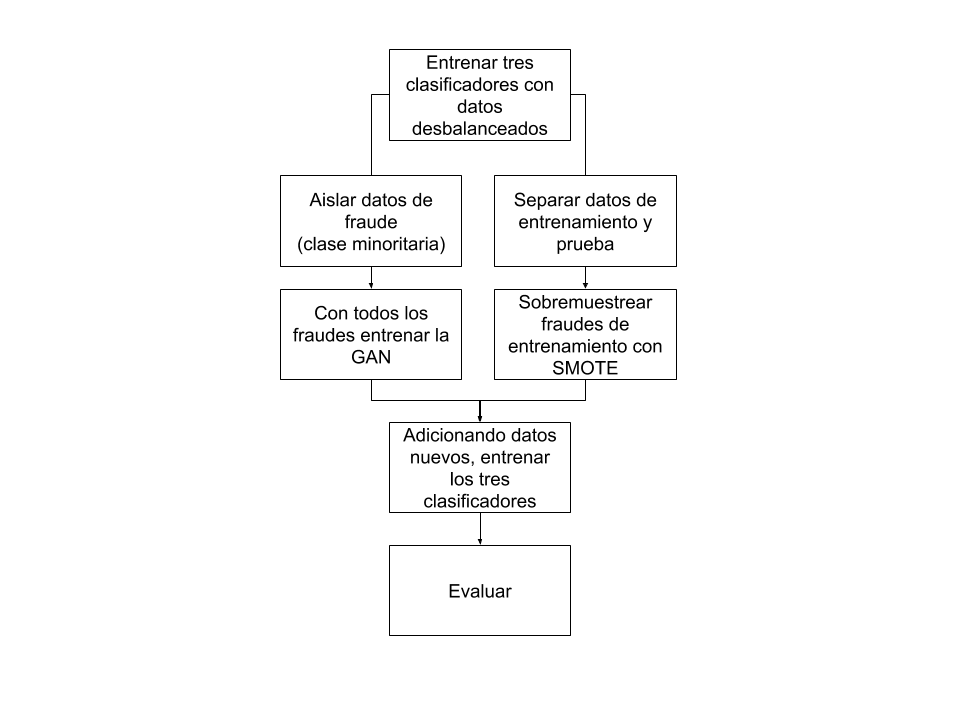


Importamos las librerías que vamos a utilizar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import xgboost as xgb

from gan import *

Los datos que vamos a utilizar se obtuvieron [aquí](https://www.kaggle.com/mlg-ulb/creditcardfraud). Este conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por usuarios de tarjetas europeos. Se tienen las transacciones que ocurrieron en dos días, donde hay 492 fraudes y 284.807 transacciones. Es el resultado de un análisis de componentes principales del set de datos original, por lo que, sumado a la necesidad de mantener la privacidad de los usuarios, las variables no contienen nombres interpretables. Ahora bien, importamos los datos:

In [2]:
data = pd.read_csv('creditcard.csv')
# columnas de descriptores
data_cols = list(data.columns[ data.columns != 'Class' ])
#columna de etiqueta
label_cols = ['Class']

In [3]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## 3. Exploración de Datos

In [82]:
data.drop(['Class', 'Time'], axis = 1).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


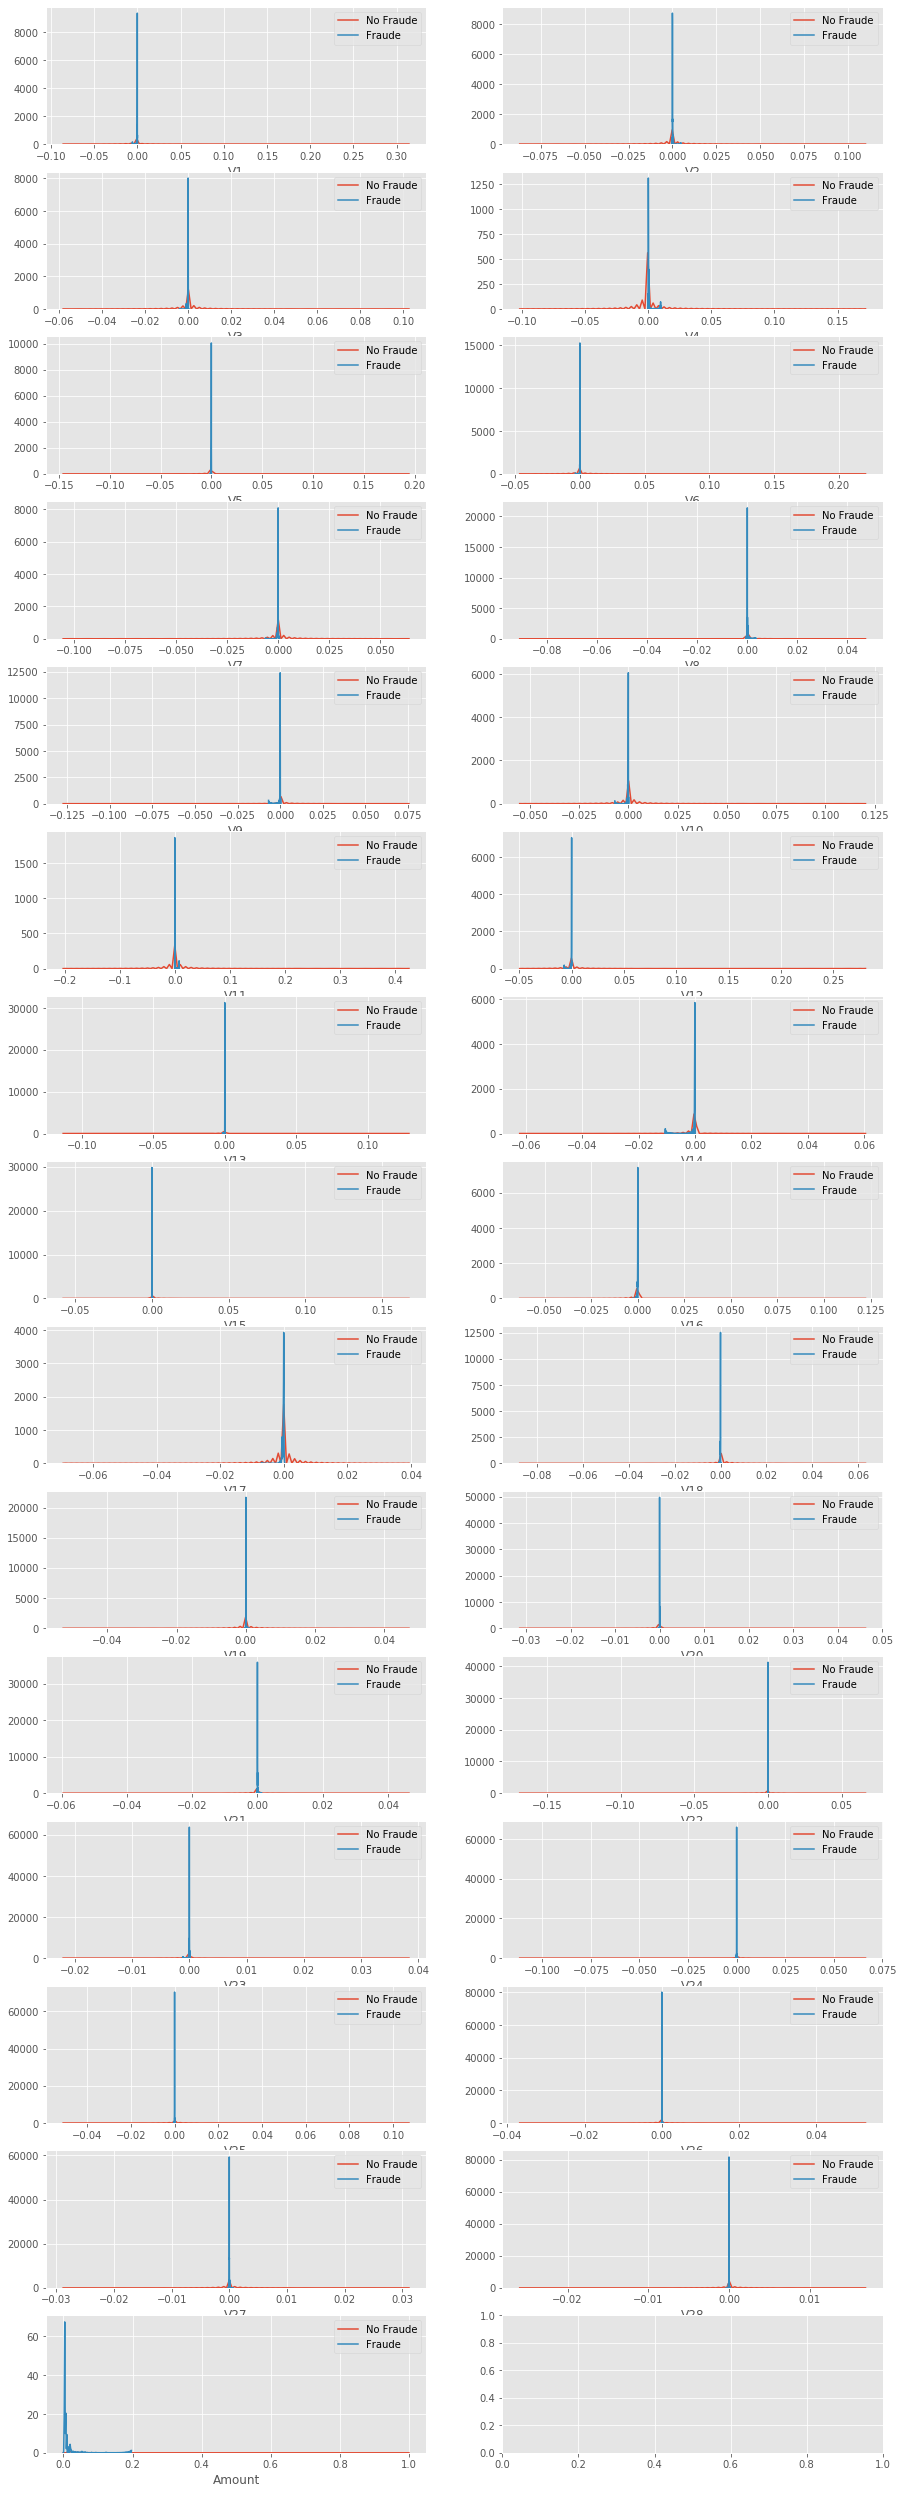

In [205]:
import warnings
import seaborn as sns 
#warnings.filterwarnings('ignore')
n_filas = 15
n_columnas = 2
lista_variables = data.drop(['Class', 'Time'], axis = 1).columns
f, axes = plt.subplots(n_filas, n_columnas, figsize=(15, 45))
total = n_filas*n_columnas
k = 0
for i in range(n_filas):
   
    for j in range(n_columnas):
        if k < 29:
            sns.distplot(data[data['Class']==0][lista_variables[k]].dropna(),hist = False, kde = True, label = 'No Fraude',ax=axes[i, j]);
            sns.distplot(data[data['Class']==1][lista_variables[k]].dropna(), hist = False, kde = True, label = 'Fraude',ax=axes[i, j]);
            k = k + 1;

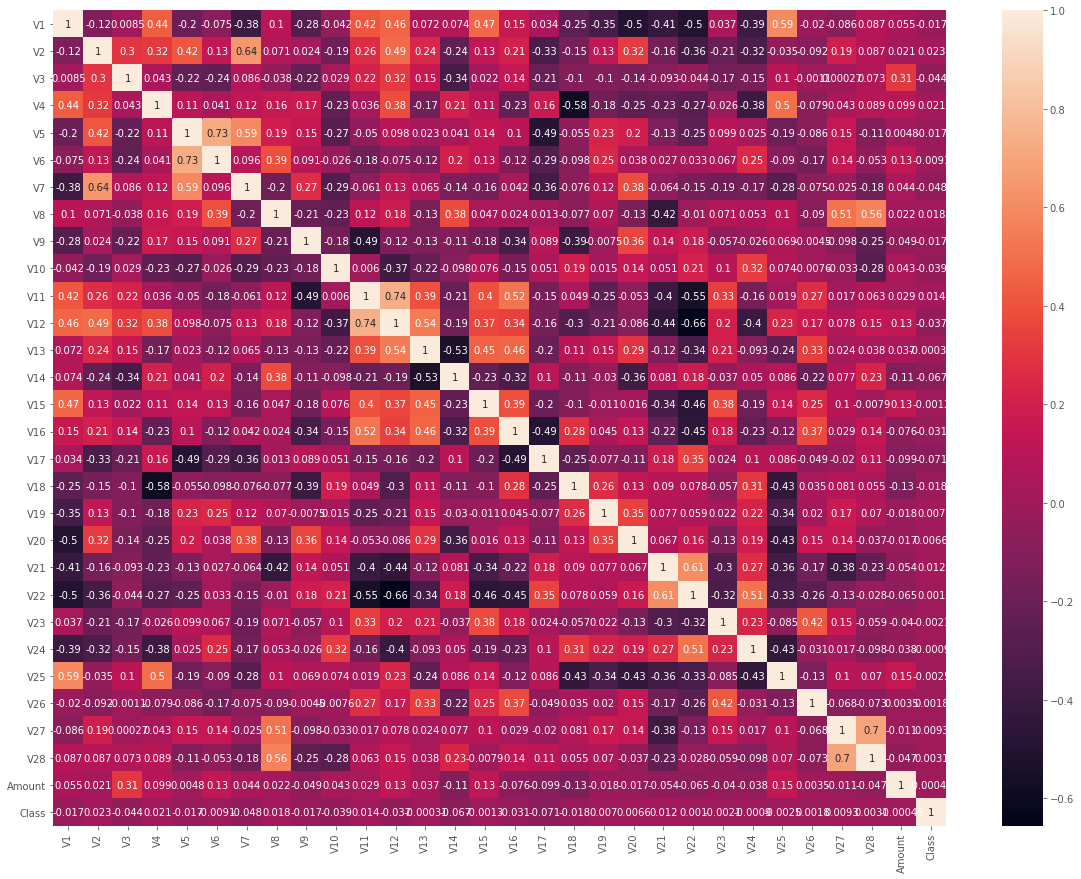

In [195]:
matriz_correlacion=data.drop(['Time'], axis = 1).corr()
plt.subplots(figsize=(20,15))
sns.heatmap(matriz_correlacion, annot=True)

## 4. Separación de Datos

Como mencionamos anteriormente, utilizamos una proporción de 70/30 para los datos de entrenamiento y prueba. Esta proporción se mantiene para mbas clases, por lo que es necesario separar datos de fraude de los realizados legalmente, hacer la partición de entrenamiento y prueba para cada clase:

In [4]:
from sklearn.model_selection import train_test_split

fraude = data.loc[ data.Class==1 ].copy()
datos_x_fraude = fraude.drop(['Class'], axis = 1)
datos_y_fraude = fraude.Class
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(datos_x_fraude, datos_y_fraude, random_state = 0, test_size=0.3)

legal = data.loc[ data.Class==0 ].copy()
datos_x_legal = legal.drop(['Class'], axis = 1)
datos_y_legal = legal.Class
x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(datos_x_legal, datos_y_legal, random_state = 0, test_size=0.3)

Ahora juntamos los datos con su correspondiente etiqueta y los separamos en entrenamiento y prueba. Con ayuda de la librería *shuffle* permutamos los datos para que no queden organizados. Una vez permutados, volvemos a separar los descriptores de su etiqueta, tanto para entrenamiento como para prueba.

In [5]:
from sklearn.utils import shuffle
#juntamos X y Y
entrenamiento_fraude = pd.concat([x_train_f, y_train_f], axis = 1)
entrenamiento_legal  = pd.concat([x_train_l, y_train_l], axis = 1)
test_fraude = pd.concat([x_test_f, y_test_f], axis = 1)
test_legal  = pd.concat([x_test_l, y_test_l], axis = 1)

#juntamos fraude y legal
train = pd.concat([entrenamiento_fraude, entrenamiento_legal])
test  = pd.concat([test_fraude, test_legal])

#permutamos
train_p = shuffle(train).reset_index(drop = True)
test_p  = shuffle(test).reset_index(drop = True)
#sacamos X y Y
X_train, y_train = train_p.drop(['Class'], axis = 1), train_p.Class
X_test, y_test   = test_p.drop(['Class'], axis = 1), test_p.Class

Una vez organizados los datos, dado que se trata de una tarea de clasificación, normalizamos nuestros descriptores:

In [6]:
from sklearn import preprocessing
def normalizar(pDatos_Para_Normalizar, pDatos):
    #Se inicializa el preprocesamiento de los datos
    normalizar = preprocessing.Normalizer().fit(pDatos_Para_Normalizar) #se obtiene una funcion que permita a 
    #partir de la media y los valores maximos y minimos de los datos de entrenamiento de este modelo, normalizar los datos de prueba y de entrenamiento
    dato_normal = normalizar.transform(pDatos) #Datos normailzados y con los cuales se entrenarán los modelos 
    return dato_normal
# Normalizamos los datos
X_train_norm = normalizar(X_train, X_train)
X_test_norm = normalizar(X_train, X_test)

# 5. Clasificadores: Entrenamiento sin datos sintéticos

Ahora entrenamos nuestros tres clasificadores con los datos normalizados, los cuales siguen estando desbalanceados. Los tres modelos son regresión logística, random forest y gradient boosting:

### 5.1. Regresión Logística

In [179]:
from sklearn.linear_model import LogisticRegression
w = {0:344, 1:(y_train.shape[0]-492)}
m1_lr = LogisticRegression(max_iter=10000, class_weight = w)
m1_lr.fit(X_train_norm, y_train)

LogisticRegression(class_weight={0: 492, 1: 198872}, max_iter=10000)

### 5.2. Random Forest

In [133]:
from sklearn.ensemble import RandomForestClassifier
w = {0:344, 1:(y_train.shape[0]-492)}
m1_rf = RandomForestClassifier(class_weight = w)
m1_rf.fit(X_train_norm, y_train)

RandomForestClassifier()

### 5.3 Gradient Boosting

Creamos las métricas de evaluación que utilizaremos para nuestro gradient boosting:

In [147]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall1(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds), average='micro')

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

Entrenamos el modelo:

In [150]:
# Run the xgboost algorithm, maximize recall on the test set
dtrain = xgb.DMatrix(X_train_norm, y_train, feature_names = X_train.columns)
dtest = xgb.DMatrix(X_test_norm, y_test, feature_names = X_test.columns)

results_dict = {}

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc'
}

m1_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall1, maximize=True
                    )

## 6. Creación de Fraudes Sintéticos

Como mencionamos anteriormente, el principal aporte de este proyecto es lograr crear nuevos datos de fraude para balancear nuestro set de datos y así mejorar el desempeño de los tres modelos seleccionados. Para esto utilizaremos dos técnicas, redes generativas adversariales y sobremuestreo de minorías sintéticas. Primero acomodamos los datos de la forma en la que los modelos los consumen, acomodando entrenamiento, prueba y todo junto en dataframes. Asimismo, aislamos los fraudes normalizados, que usaremos en nuestra primera técnica de creación de fraudes sintéticos.

In [7]:
train_norm = pd.concat([pd.DataFrame(X_train_norm), y_train], axis = 1)
train_norm.columns = fraude.columns
test_norm = pd.concat([pd.DataFrame(X_test_norm), y_test], axis = 1)
test_norm.columns = fraude.columns
todo_norm = pd.concat([train_norm, test_norm])
fraudes_norm = todo_norm[todo_norm.Class == 1]
fraudes_norm.columns = fraude.columns
fraudes_norm

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
295,0.999894,-3.278928e-04,0.000250,-0.000096,0.000263,-0.000154,0.000026,-0.000077,-2.644387e-04,0.000228,...,1.362452e-04,-6.361362e-06,1.563063e-05,3.868678e-05,-4.087384e-05,-3.306862e-05,-0.000245,-5.087860e-05,0.014495,1
989,0.999998,-1.132788e-04,0.000077,-0.000188,0.000087,-0.000108,-0.000048,-0.000138,7.227333e-05,-0.000050,...,2.892980e-05,7.411051e-06,-1.212572e-05,4.894963e-06,4.116093e-06,5.566134e-06,-0.000015,-5.202493e-06,0.002009,1
1197,1.000000,-2.711618e-05,0.000025,-0.000052,0.000051,-0.000005,-0.000013,-0.000023,7.042920e-07,-0.000010,...,3.597002e-06,4.522439e-06,2.826722e-06,-4.080272e-06,-2.430593e-06,2.415211e-06,-0.000018,2.742315e-06,0.000007,1
2803,1.000000,7.947169e-06,0.000021,-0.000041,0.000037,0.000012,-0.000012,-0.000006,1.781190e-06,-0.000021,...,8.332592e-07,-5.525733e-06,-5.358115e-07,1.933505e-07,2.613829e-06,4.035727e-07,0.000003,2.190210e-06,0.000000,1
3140,0.999997,-7.510978e-04,0.000410,-0.001099,0.000585,-0.000429,-0.000114,-0.000797,2.522528e-05,-0.000312,...,-1.159202e-04,5.252883e-05,5.339436e-05,-5.114078e-05,-8.951684e-06,3.196533e-05,0.000106,-6.919179e-05,0.000049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83320,0.999982,8.867744e-06,-0.000004,-0.000026,0.000051,0.000008,-0.000006,0.000014,-5.542297e-06,-0.000001,...,-1.165008e-06,-1.324645e-05,-3.416595e-06,-4.423418e-06,-2.311664e-06,-2.831618e-06,-0.000002,1.100158e-06,0.006019,1
83738,1.000000,-1.113631e-04,0.000027,-0.000124,0.000094,-0.000054,-0.000032,-0.000118,4.739086e-05,-0.000065,...,1.918812e-05,2.273281e-06,1.065958e-05,-1.028241e-05,1.053723e-05,-7.698765e-07,0.000017,2.874582e-06,0.000015,1
84340,1.000000,-6.591005e-05,0.000076,-0.000139,0.000085,-0.000084,-0.000042,-0.000130,5.296827e-05,-0.000045,...,2.666694e-05,5.132400e-06,5.124587e-06,3.839180e-06,-3.125678e-06,-2.122395e-06,-0.000002,4.250552e-06,0.000478,1
84735,0.999975,-5.377610e-07,-0.000026,-0.000017,0.000001,-0.000009,-0.000005,0.000010,-3.052237e-06,0.000010,...,4.553553e-06,-1.181397e-06,-5.968503e-06,7.234359e-07,-4.641363e-07,-7.296092e-06,-0.000001,8.179574e-07,0.007109,1


### 6.1. Generative Adversarial Network

Para el desarrollo de esta técnica, dada su alta complejidad de implementación, fue necesario tomar la que fue desarrollada en [este repositorio](https://github.com/mjdietzx/GAN-Sandbox). Sin embargo, para que funcionara apropiadamente fue necesario realizar algunas modificaciones mínimas, como eliminar las capas convolucionales y adaptar las funciones, por lo que se depende del archivo *gan.py* adjunto en esta entrega para que corra apropiadamente. Ahora bien, alistamos todos los parámetros que nuestra GAN utiliza:

In [225]:
rand_dim = 32 # dimensión de los datos
base_n_count = 128 
nb_steps = 10000 + 1
batch_size = 128 
k_d = 1  #número de actualizaciones de la red por paso de entrenamiento
k_g = 1  # número de actualizaciones de la red generadora en cada paso del entrenamiento
critic_pre_train_steps = 100 # número de pasos para pre-entrenarantes de comenzar el entrenamiento
log_interval = 100 # intervalo de pasos entre los cuales el modelo muestra gráficas y resumen de como va el entrenamiento
learning_rate = 5e-5
data_dir = 'cache/' #el directorio donde se guarda el modelo, para después cargarlo y crear datos
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
show = True 
label_cols = ['Class']
data_cols = [ i for i in fraudes_norm.columns if 'Class' not in i ]
train_no_label = fraudes_norm[data_cols]

En particular, vamos a utilizar la arquitectura *vanilla GAN*. Llamamos la función que importamos del archivo *gan.py*, con el cual entrenamos nuestra GAN. Cada 100 pasos se va mostrando las gráficas de la distribución de los datos originales y los que nuestra red generativa adversarial va generando, en este caso comparando el tiempo cpn la primera variable. Como podemos observar y como esperabamos inicialmente, los datos generados van haciendose más y más similares a los originales:

data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_27 (Dense)             (None, 30)                15390     
Total params: 184,222
T

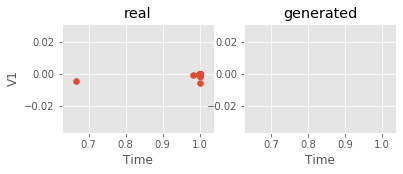

Step: 100 of 10001.
Losses: G, D Gen, D Real, Xgb: 0.8620, 0.5567, 0.6975, 0.9878
D Real - D Gen: 0.1407


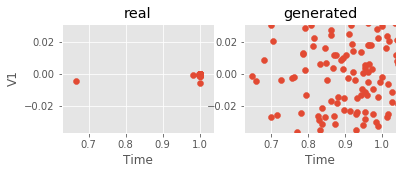

Step: 200 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.0518, 0.4452, 0.6843, 0.9959
D Real - D Gen: 0.2391


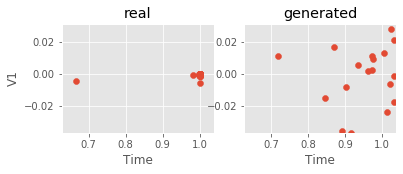

Step: 300 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.2770, 0.3515, 0.6231, 0.9959
D Real - D Gen: 0.2716


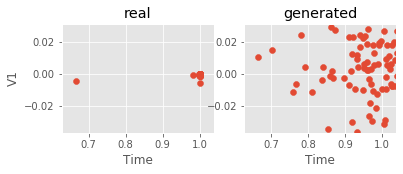

Step: 400 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.4608, 0.3011, 0.4903, 1.0000
D Real - D Gen: 0.1892


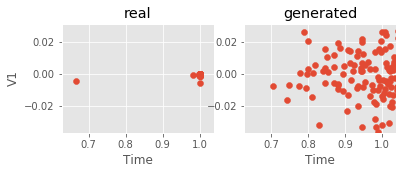

Step: 500 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.6729, 0.2434, 0.4212, 0.9939
D Real - D Gen: 0.1779


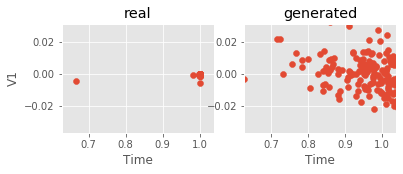

Step: 600 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.7154, 0.2498, 0.3098, 0.9898
D Real - D Gen: 0.0600


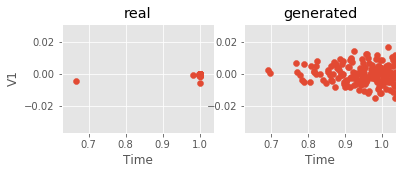

Step: 700 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.6576, 0.2838, 0.2859, 0.9959
D Real - D Gen: 0.0021


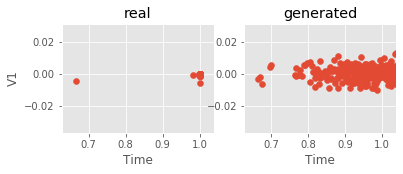

Step: 800 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.6936, 0.3123, 0.2669, 0.9858
D Real - D Gen: -0.0453


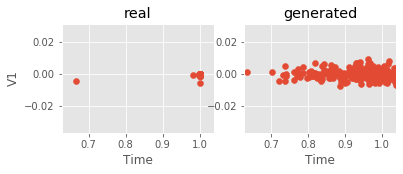

Step: 900 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.9016, 0.2833, 0.2914, 0.9939
D Real - D Gen: 0.0082


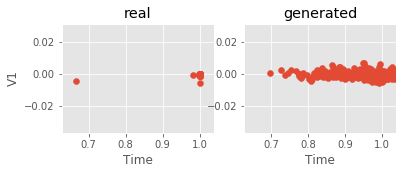

Step: 1000 of 10001.
Losses: G, D Gen, D Real, Xgb: 2.1420, 0.2804, 0.2745, 0.9980
D Real - D Gen: -0.0059


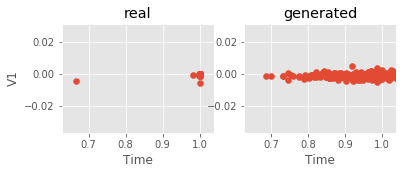

Step: 1100 of 10001.
Losses: G, D Gen, D Real, Xgb: 2.5871, 0.2574, 0.2622, 0.9959
D Real - D Gen: 0.0048


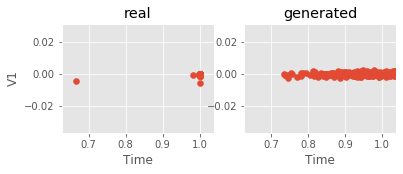

Step: 1200 of 10001.
Losses: G, D Gen, D Real, Xgb: 2.6465, 0.3202, 0.3328, 0.9959
D Real - D Gen: 0.0125


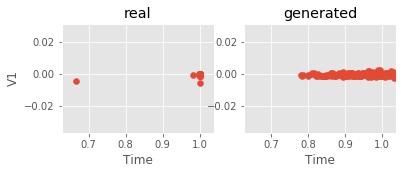

Step: 1300 of 10001.
Losses: G, D Gen, D Real, Xgb: 2.6905, 0.3107, 0.2956, 0.9959
D Real - D Gen: -0.0151


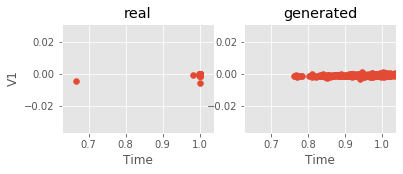

Step: 1400 of 10001.
Losses: G, D Gen, D Real, Xgb: 2.9338, 0.3566, 0.2529, 0.9858
D Real - D Gen: -0.1037


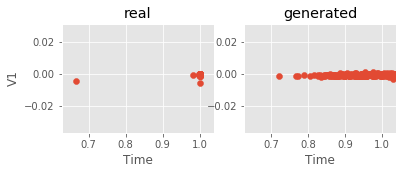

Step: 1500 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.2463, 0.2882, 0.2848, 0.9980
D Real - D Gen: -0.0034


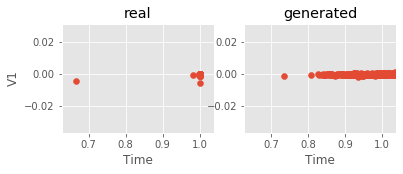

Step: 1600 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.2027, 0.2038, 0.1757, 0.9878
D Real - D Gen: -0.0282


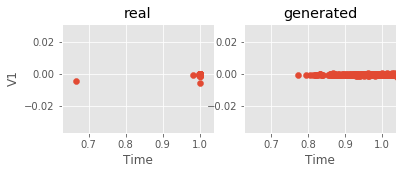

Step: 1700 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.1222, 0.1432, 0.1702, 0.9959
D Real - D Gen: 0.0270


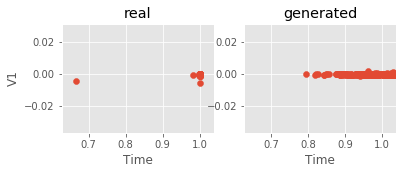

Step: 1800 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.3376, 0.2463, 0.2322, 0.9797
D Real - D Gen: -0.0142


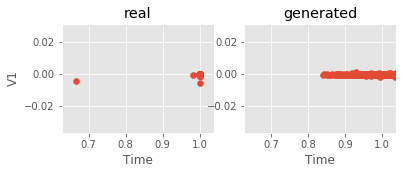

Step: 1900 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.2199, 0.1472, 0.1698, 0.9858
D Real - D Gen: 0.0227


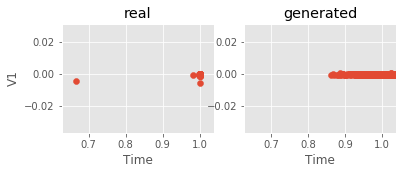

Step: 2000 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.4350, 0.1200, 0.1620, 0.9919
D Real - D Gen: 0.0420


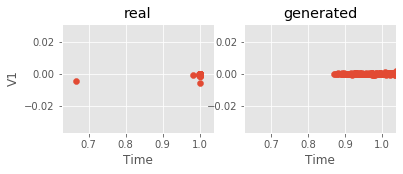

Step: 2100 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.2683, 0.0965, 0.0940, 0.9837
D Real - D Gen: -0.0025


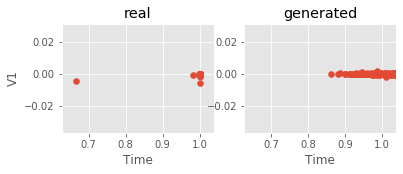

Step: 2200 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.6457, 0.0235, 0.1747, 0.9837
D Real - D Gen: 0.1512


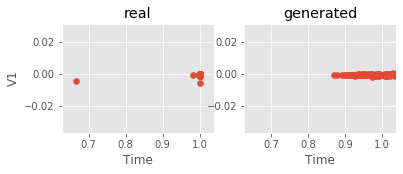

Step: 2300 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.9187, 0.2323, 0.0459, 0.9878
D Real - D Gen: -0.1863


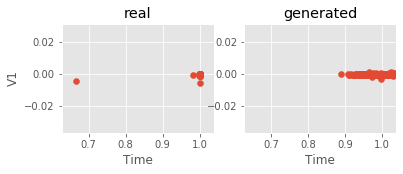

Step: 2400 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.3953, 0.0712, 0.0698, 0.9919
D Real - D Gen: -0.0014


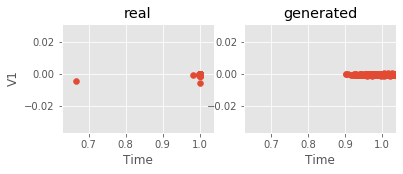

Step: 2500 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.9376, 0.1001, 0.0826, 0.9878
D Real - D Gen: -0.0175


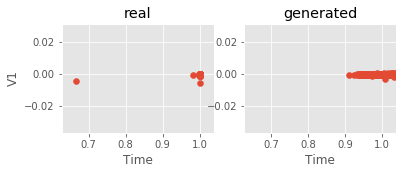

Step: 2600 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.0718, 0.0397, 0.0556, 0.9858
D Real - D Gen: 0.0159


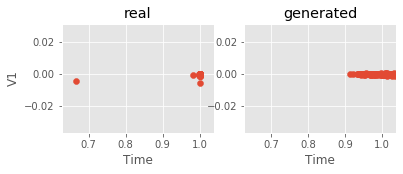

Step: 2700 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.7714, 0.0585, 0.3885, 0.9858
D Real - D Gen: 0.3300


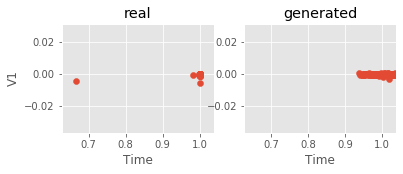

Step: 2800 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.3974, 0.4177, 0.0345, 0.9959
D Real - D Gen: -0.3832


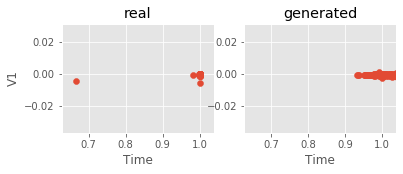

Step: 2900 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.5705, 0.3072, 0.0643, 0.9797
D Real - D Gen: -0.2429


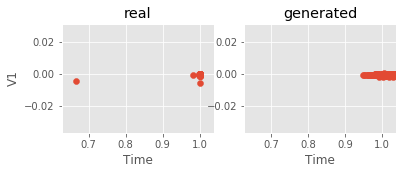

Step: 3000 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.9527, 0.0380, 0.0646, 0.9959
D Real - D Gen: 0.0266


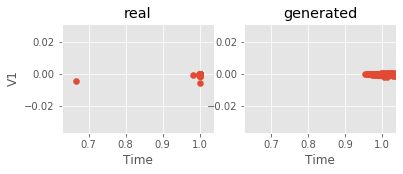

Step: 3100 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.6496, 0.0139, 0.2234, 0.9919
D Real - D Gen: 0.2095


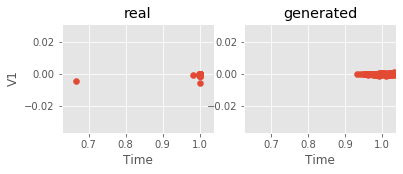

Step: 3200 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.8734, 0.0093, 0.2097, 0.9959
D Real - D Gen: 0.2004


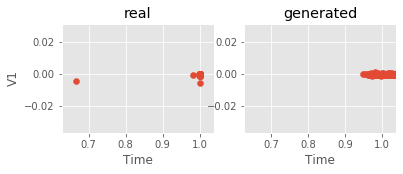

Step: 3300 of 10001.
Losses: G, D Gen, D Real, Xgb: 11.7653, 0.0066, 0.6293, 0.9939
D Real - D Gen: 0.6228


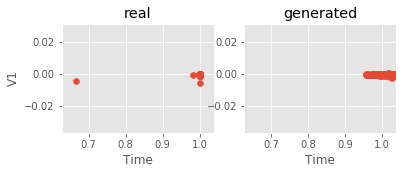

Step: 3400 of 10001.
Losses: G, D Gen, D Real, Xgb: 6.2942, 0.0103, 0.8071, 0.9939
D Real - D Gen: 0.7968


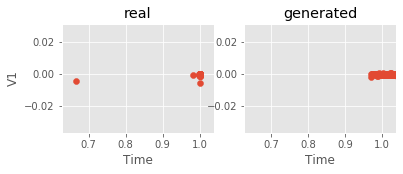

Step: 3500 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.8880, 0.7263, 0.0464, 0.9980
D Real - D Gen: -0.6800


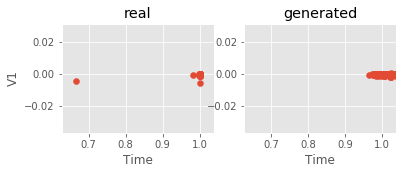

Step: 3600 of 10001.
Losses: G, D Gen, D Real, Xgb: 7.3486, 0.0051, 0.6482, 1.0000
D Real - D Gen: 0.6432


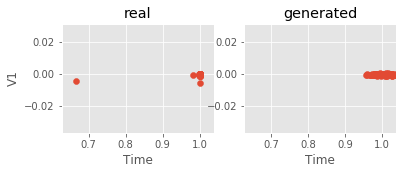

Step: 3700 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.0338, 0.0261, 0.6092, 0.9858
D Real - D Gen: 0.5831


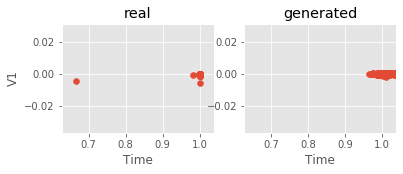

Step: 3800 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.5645, 2.1057, 0.0580, 0.9919
D Real - D Gen: -2.0477


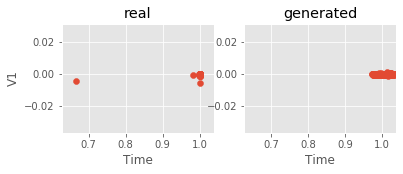

Step: 3900 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.1148, 0.7912, 0.0950, 0.9980
D Real - D Gen: -0.6962


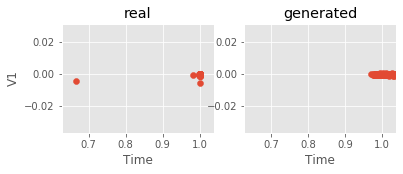

Step: 4000 of 10001.
Losses: G, D Gen, D Real, Xgb: 11.3192, 0.0059, 0.5157, 0.9898
D Real - D Gen: 0.5099


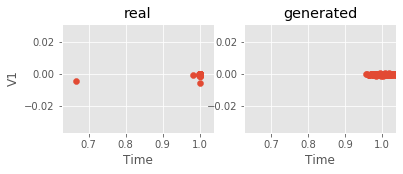

Step: 4100 of 10001.
Losses: G, D Gen, D Real, Xgb: 6.1872, 0.0095, 0.3104, 0.9878
D Real - D Gen: 0.3009


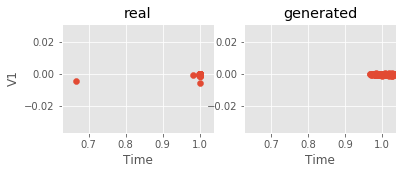

Step: 4200 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.0893, 0.0244, 0.5427, 0.9919
D Real - D Gen: 0.5182


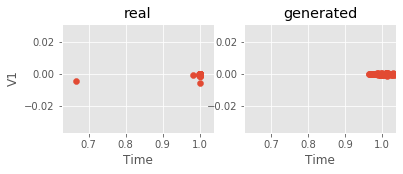

Step: 4300 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.1059, 0.1047, 0.3200, 0.9858
D Real - D Gen: 0.2153


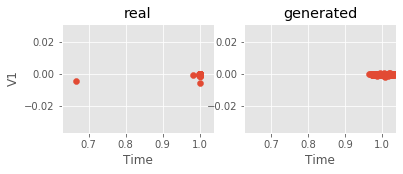

Step: 4400 of 10001.
Losses: G, D Gen, D Real, Xgb: 19.5263, 0.0104, 0.3686, 0.9980
D Real - D Gen: 0.3582


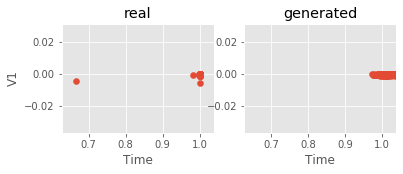

Step: 4500 of 10001.
Losses: G, D Gen, D Real, Xgb: 7.8771, 0.0058, 0.8968, 0.9858
D Real - D Gen: 0.8911


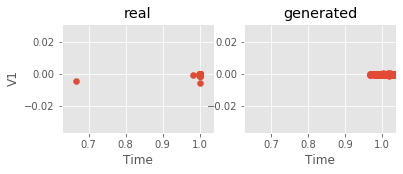

Step: 4600 of 10001.
Losses: G, D Gen, D Real, Xgb: 8.4278, 0.0075, 1.0054, 0.9919
D Real - D Gen: 0.9979


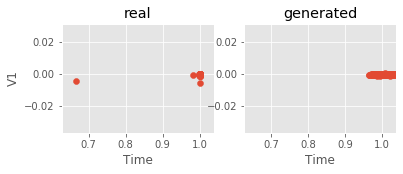

Step: 4700 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.7514, 0.6191, 1.7067, 0.9939
D Real - D Gen: 1.0877


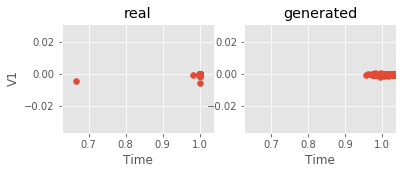

Step: 4800 of 10001.
Losses: G, D Gen, D Real, Xgb: 7.3730, 0.0051, 0.1406, 0.9776
D Real - D Gen: 0.1355


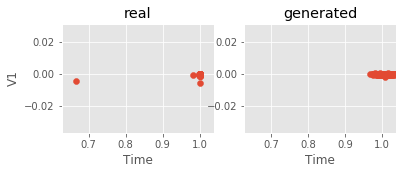

Step: 4900 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.5299, 0.5465, 0.0642, 0.9898
D Real - D Gen: -0.4823


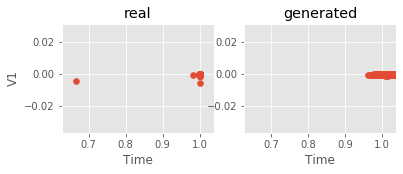

Step: 5000 of 10001.
Losses: G, D Gen, D Real, Xgb: 6.4328, 0.8203, 0.0540, 0.9919
D Real - D Gen: -0.7663


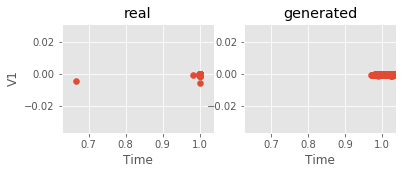

Step: 5100 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.0006, 0.0333, 0.8375, 0.9837
D Real - D Gen: 0.8042


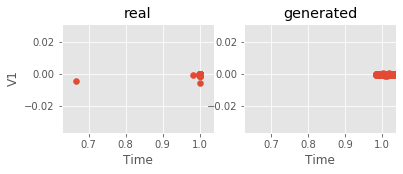

Step: 5200 of 10001.
Losses: G, D Gen, D Real, Xgb: 0.9947, 2.5054, 0.0471, 0.9715
D Real - D Gen: -2.4583


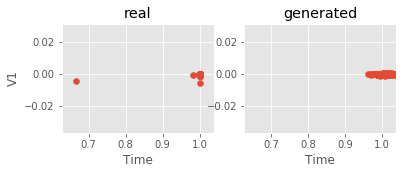

Step: 5300 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.4168, 1.0648, 0.2044, 0.9959
D Real - D Gen: -0.8603


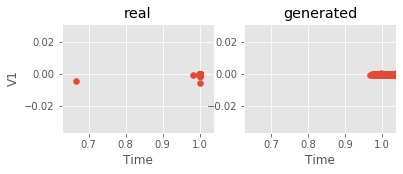

Step: 5400 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.7253, 1.1763, 0.0536, 0.9939
D Real - D Gen: -1.1227


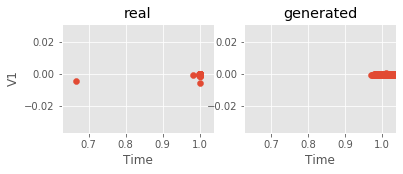

Step: 5500 of 10001.
Losses: G, D Gen, D Real, Xgb: 6.1053, 0.0081, 0.2191, 0.9797
D Real - D Gen: 0.2110


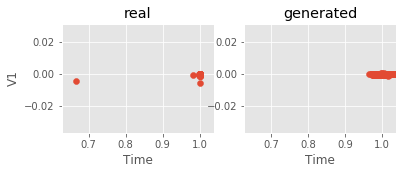

Step: 5600 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.9361, 0.0255, 0.3968, 0.9919
D Real - D Gen: 0.3714


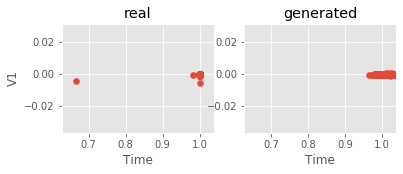

Step: 5700 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.5691, 0.0138, 0.1031, 0.9919
D Real - D Gen: 0.0893


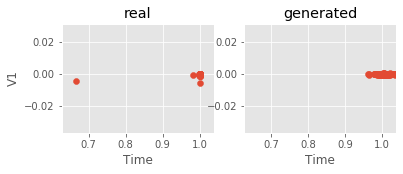

Step: 5800 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.1453, 0.3368, 0.1534, 0.9898
D Real - D Gen: -0.1834


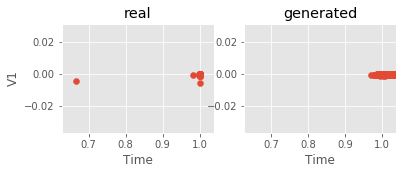

Step: 5900 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.8750, 0.0898, 0.0760, 0.9837
D Real - D Gen: -0.0137


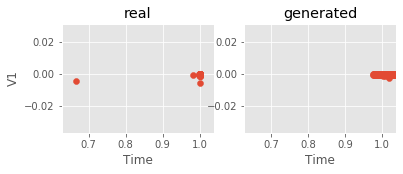

Step: 6000 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.3380, 0.0122, 0.1390, 0.9878
D Real - D Gen: 0.1268


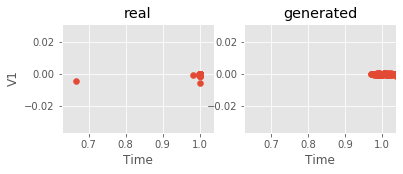

Step: 6100 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.8590, 0.0068, 0.8907, 0.9756
D Real - D Gen: 0.8839


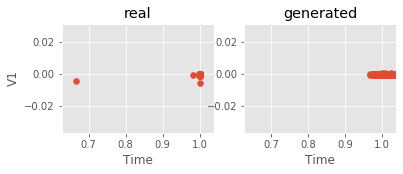

Step: 6200 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.9147, 0.3746, 0.0787, 0.9980
D Real - D Gen: -0.2959


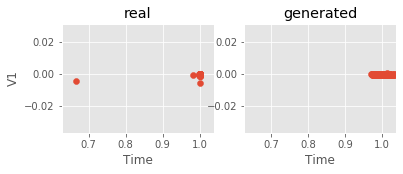

Step: 6300 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.7204, 1.0348, 0.0701, 0.9980
D Real - D Gen: -0.9646


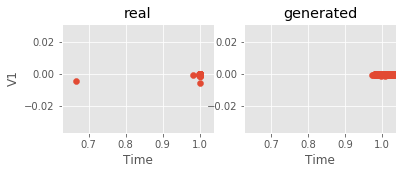

Step: 6400 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.7690, 0.0110, 0.9222, 0.9837
D Real - D Gen: 0.9112


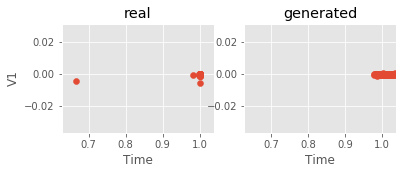

Step: 6500 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.3688, 0.0374, 0.0587, 0.9919
D Real - D Gen: 0.0214


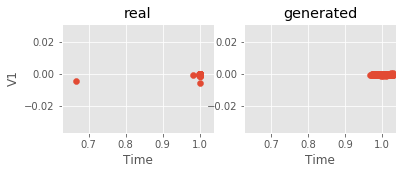

Step: 6600 of 10001.
Losses: G, D Gen, D Real, Xgb: 14.3005, 0.0080, 0.0542, 0.9939
D Real - D Gen: 0.0463


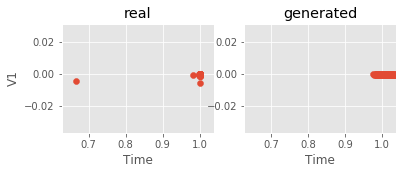

Step: 6700 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.7484, 0.0434, 0.1574, 0.9919
D Real - D Gen: 0.1140


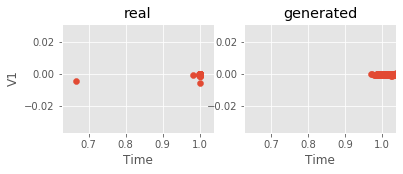

Step: 6800 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.3945, 0.0947, 0.0710, 0.9898
D Real - D Gen: -0.0237


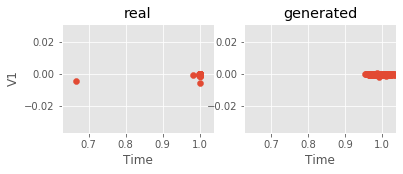

Step: 6900 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.3125, 0.0330, 0.0703, 0.9980
D Real - D Gen: 0.0373


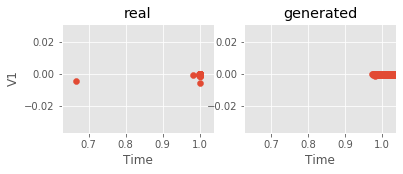

Step: 7000 of 10001.
Losses: G, D Gen, D Real, Xgb: 18.5725, 0.0091, 0.3775, 0.9919
D Real - D Gen: 0.3684


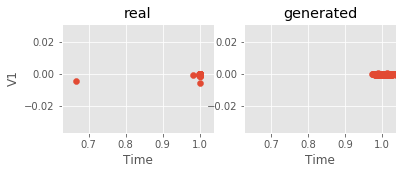

Step: 7100 of 10001.
Losses: G, D Gen, D Real, Xgb: 1.4443, 1.9136, 0.0789, 0.9797
D Real - D Gen: -1.8347


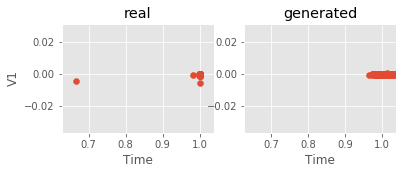

Step: 7200 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.3072, 0.9961, 0.1345, 0.9878
D Real - D Gen: -0.8616


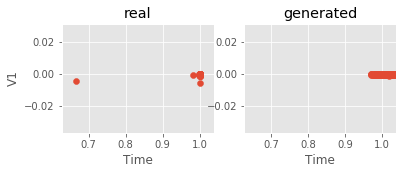

Step: 7300 of 10001.
Losses: G, D Gen, D Real, Xgb: 7.3422, 0.0075, 0.7854, 0.9959
D Real - D Gen: 0.7779


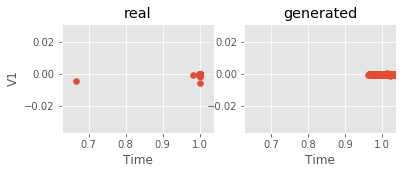

Step: 7400 of 10001.
Losses: G, D Gen, D Real, Xgb: 2.8362, 0.3240, 0.9788, 0.9878
D Real - D Gen: 0.6548


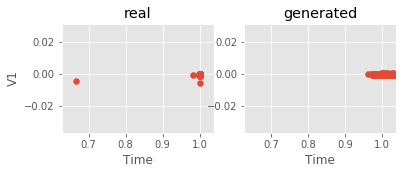

Step: 7500 of 10001.
Losses: G, D Gen, D Real, Xgb: 9.3974, 0.0047, 0.0488, 0.9959
D Real - D Gen: 0.0441


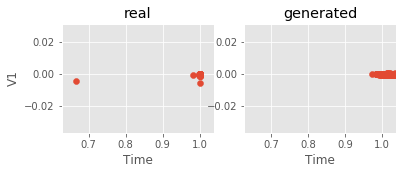

Step: 7600 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.0243, 0.0342, 0.1070, 1.0000
D Real - D Gen: 0.0729


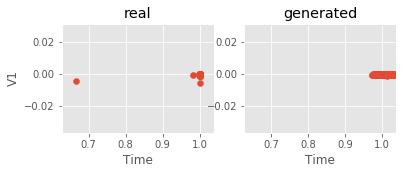

Step: 7700 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.9435, 0.0668, 0.2298, 0.9878
D Real - D Gen: 0.1630


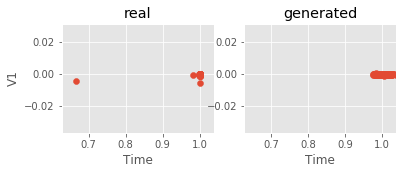

Step: 7800 of 10001.
Losses: G, D Gen, D Real, Xgb: 8.9585, 0.0047, 1.0675, 0.9959
D Real - D Gen: 1.0628


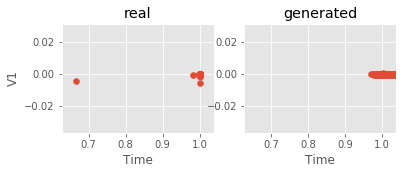

Step: 7900 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.6879, 0.4871, 0.0562, 0.9858
D Real - D Gen: -0.4309


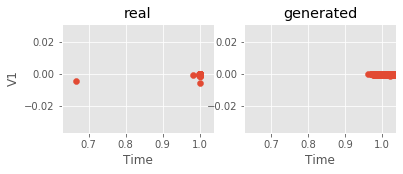

Step: 8000 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.8804, 0.0559, 0.1832, 1.0000
D Real - D Gen: 0.1273


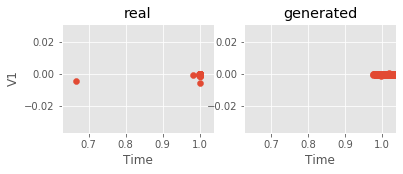

Step: 8100 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.0086, 0.2811, 0.0788, 0.9959
D Real - D Gen: -0.2023


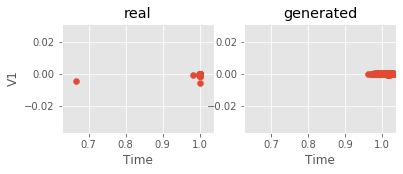

Step: 8200 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.7731, 0.1275, 0.1772, 0.9919
D Real - D Gen: 0.0496


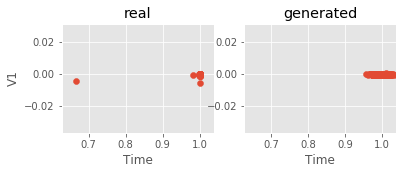

Step: 8300 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.2516, 0.0589, 0.0569, 0.9959
D Real - D Gen: -0.0020


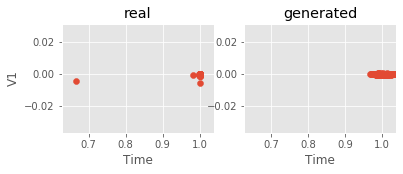

Step: 8400 of 10001.
Losses: G, D Gen, D Real, Xgb: 8.7696, 0.0046, 0.0557, 0.9919
D Real - D Gen: 0.0511


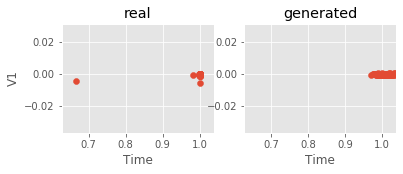

Step: 8500 of 10001.
Losses: G, D Gen, D Real, Xgb: 9.2104, 0.0050, 0.1010, 0.9858
D Real - D Gen: 0.0960


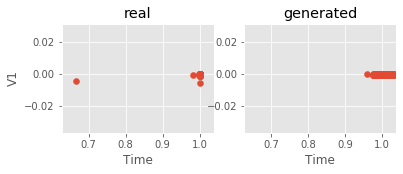

Step: 8600 of 10001.
Losses: G, D Gen, D Real, Xgb: 11.6194, 0.0063, 0.6139, 0.9919
D Real - D Gen: 0.6076


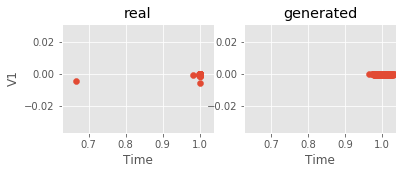

Step: 8700 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.0979, 0.8472, 0.0620, 0.9939
D Real - D Gen: -0.7852


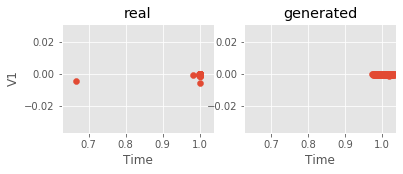

Step: 8800 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.2604, 0.0171, 0.0805, 0.9959
D Real - D Gen: 0.0634


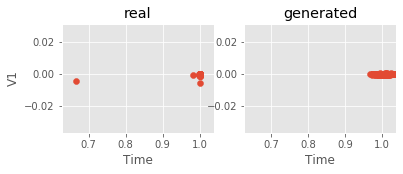

Step: 8900 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.6010, 0.0172, 0.0991, 0.9878
D Real - D Gen: 0.0818


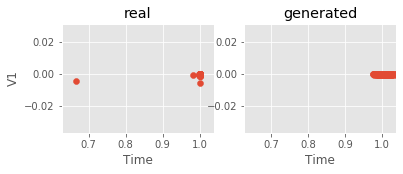

Step: 9000 of 10001.
Losses: G, D Gen, D Real, Xgb: 12.6377, 0.0065, 0.0577, 0.9919
D Real - D Gen: 0.0512


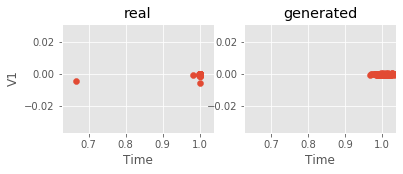

Step: 9100 of 10001.
Losses: G, D Gen, D Real, Xgb: 5.3118, 0.0958, 0.0675, 0.9898
D Real - D Gen: -0.0282


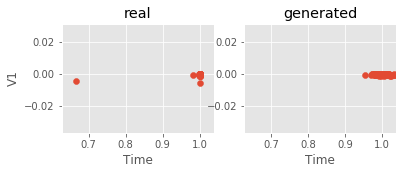

Step: 9200 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.1018, 0.1631, 0.1849, 0.9939
D Real - D Gen: 0.0218


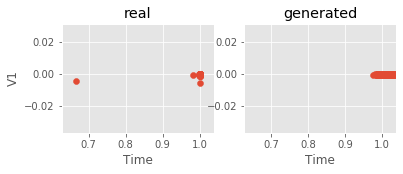

Step: 9300 of 10001.
Losses: G, D Gen, D Real, Xgb: 6.3370, 0.3708, 0.0491, 0.9837
D Real - D Gen: -0.3218


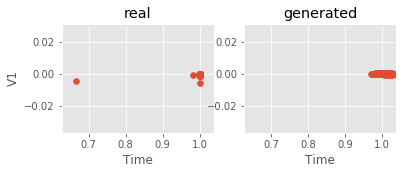

Step: 9400 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.5283, 0.1149, 0.9331, 0.9959
D Real - D Gen: 0.8182


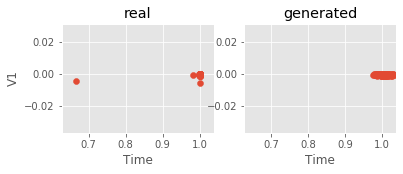

Step: 9500 of 10001.
Losses: G, D Gen, D Real, Xgb: 3.7653, 0.1350, 0.0736, 0.9878
D Real - D Gen: -0.0613


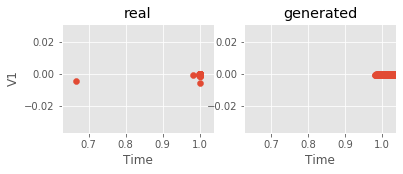

Step: 9600 of 10001.
Losses: G, D Gen, D Real, Xgb: 7.0602, 0.0051, 0.0655, 0.9980
D Real - D Gen: 0.0604


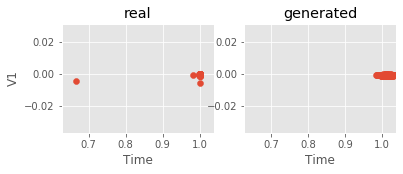

Step: 9700 of 10001.
Losses: G, D Gen, D Real, Xgb: 12.8929, 0.0061, 0.0383, 0.9939
D Real - D Gen: 0.0322


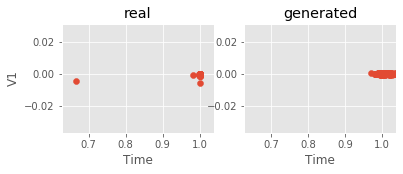

Step: 9800 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.8777, 0.0903, 0.0868, 0.9878
D Real - D Gen: -0.0035


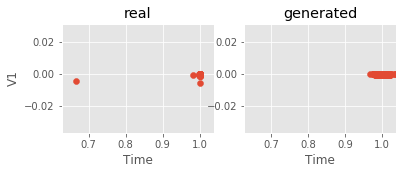

Step: 9900 of 10001.
Losses: G, D Gen, D Real, Xgb: 4.6016, 0.3514, 0.0355, 0.9797
D Real - D Gen: -0.3159


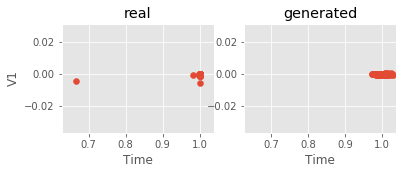

Step: 10000 of 10001.
Losses: G, D Gen, D Real, Xgb: 6.1974, 0.0050, 0.1861, 0.9837
D Real - D Gen: 0.1811


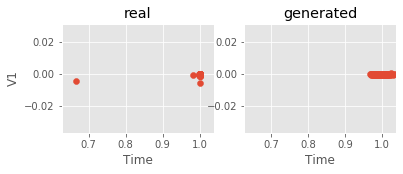

In [227]:
k_d = 1  # cantidad de actualizaciones por paso de entrenamiento de la red
learning_rate = 1e-4
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show] #argumentos de la red

adversarial_training_GAN(arguments, train_no_label, data_cols ) # entrenamos la GAN!


Una vez entrenada nuestra red generativa adversarial, genera dos archivos, uno con el discriminador y otro con el generador. A continuación creamos la red y le cargamos los pesos del generador creado en la última iteración. Con este generador de datos vamos a crear nuestros datos sintéticos.

In [235]:
data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
seed = 17
if label_dim > 0: with_class = True
np.random.seed(seed)
generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
generator_model.load_weights('cache/GAN_generator_model_weights_step_10000.h5')

In [236]:
fraudes_norm_no_label = fraudes_norm.drop('Class', axis = 1)

Con nuestra red generativa adversarial entrenada y cargada, vamos a generar 246, 492, 984 y 4920 datos de fraude.

In [246]:
datos_a_generar_GAN = [246, 492, 984, 4920, 29520]
datos_generados_GAN = []
for i in datos_a_generar_GAN:
    test_size = i
    x = get_data_batch(fraudes_norm_no_label, test_size, seed=0)
    z = np.random.normal(size=(test_size, rand_dim))
    if with_class:
        labels = x[:,-label_dim:]
        g_z = generator_model.predict([z, labels])
    else:
        g_z = generator_model.predict(z)
    df_generado = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=fraudes_norm.columns )
    datos_generados_GAN.append(df_generado)

Con los datos generados, añadimos los datos de entrenamiento normalizados para posteriormente analizar las diferencias de desempeño al generar nuevos datos en el entrenamiento.

In [247]:
train_GAN = []
for i in datos_generados_GAN:
    train_GAN.append(shuffle(pd.concat([train_norm, i], axis = 0)))

### 6.2. SMOTE 

Este método permite obtener nuevos ejemplos similares a los ejemplos existentes. Este método funciona seleccionando ejemplos que sean cercanos entre sí en el espacio generado por los decriptores, dibuja una línea entre ambos y toma como ejemplo un punto sobre esta línea. Al igual que en el caso de la GAN vamos a generar 246, 492, 984, 4920 y 29250 ejemplos nuevos. A diferencia de la GAN, acá sólo tomamos los datops de entrenamiento para la generación de nuevas instancias, pues al ser una técnica de resampleo es más propensa a tomar de forma directa información de los datos de prueba y sesgar la evaluación. Su implementación es mucho más sencilla en comparación con la GAN, pues hay librerías populares que ya tienen esta técnica implementada. A continuación utilizamos una de estas:

In [248]:
from imblearn.over_sampling import SMOTE
datos_a_generar_SMOTE = [246, 492, 984, 4920, 29520]
datos_generados_SMOTE = []
for i in datos_a_generar_SMOTE:
    oversample = SMOTE(sampling_strategy = (y_train.sum()+i+2)/(y_train.shape[0]))
    X, y = oversample.fit_resample(X_train_norm, y_train)
    X_df = pd.DataFrame(X)
    X_df.columns = fraude.columns[:-1]
    y_df = pd.DataFrame(y)
    y_df.columns = ['Class']
    datos_generados_SMOTE.append(pd.concat([X_df, y_df], axis = 1))

In [291]:
datos_generados_SMOTE[0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.000000,1.350578e-07,0.000005,-0.000004,-5.602675e-06,0.000011,7.401957e-06,3.493382e-06,0.000003,-0.000001,...,-1.488804e-06,-0.000003,5.544005e-07,-6.205624e-06,-3.518276e-06,1.320664e-06,1.555849e-06,3.304024e-07,0.000012,0
1,1.000000,-1.096232e-05,0.000012,0.000009,5.153851e-06,-0.000002,5.320472e-07,-4.583679e-07,0.000005,-0.000003,...,-1.239016e-06,-0.000003,-2.853758e-07,6.853879e-06,2.593273e-06,-4.737966e-06,-4.056356e-07,-9.116519e-07,0.000007,0
2,1.000000,-1.498853e-05,0.000022,0.000014,-2.354730e-06,-0.000002,-1.032251e-05,5.667274e-06,0.000006,-0.000006,...,-3.800830e-06,-0.000010,3.476443e-07,-1.969189e-06,-4.222388e-07,1.679691e-06,3.933638e-06,1.643632e-06,0.000153,0
3,0.999999,9.334570e-06,-0.000007,-0.000006,-5.019962e-07,0.000002,1.140557e-05,-4.433136e-06,0.000003,0.000005,...,2.303430e-06,0.000005,2.653185e-07,-5.368416e-06,-3.361325e-06,4.350492e-06,-1.883059e-07,-2.164293e-07,0.001219,0
4,1.000000,1.424143e-05,-0.000007,0.000018,1.204035e-05,-0.000019,-1.620877e-06,-1.075500e-05,0.000004,0.000013,...,-1.767961e-07,-0.000001,2.195201e-07,7.575735e-06,1.659386e-06,4.015997e-06,-1.199781e-07,3.547277e-07,0.000912,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199605,1.000000,-1.470149e-04,0.000064,-0.000165,1.184068e-04,-0.000109,-2.268414e-05,-1.646879e-04,0.000062,-0.000069,...,1.394590e-05,0.000002,-1.754257e-06,-8.811946e-07,-2.038098e-06,2.009488e-06,-1.358812e-05,-5.172453e-06,0.000228,1
199606,0.999978,-1.491977e-05,0.000030,-0.000066,3.144939e-05,-0.000041,-1.248598e-06,1.106671e-07,0.000003,-0.000009,...,1.676073e-06,0.000006,5.194117e-06,-3.212190e-06,-1.348818e-05,-5.136829e-06,4.093512e-06,-6.597115e-07,0.006621,1
199607,1.000000,-2.038824e-06,0.000015,-0.000044,1.783338e-05,-0.000006,-6.266211e-06,-2.132002e-05,0.000009,-0.000011,...,7.172969e-06,0.000007,-1.066840e-06,-7.710366e-06,-4.421116e-07,-1.451290e-07,5.228165e-06,2.670350e-06,0.000848,1
199608,0.999999,-1.462170e-04,0.000112,-0.000228,1.612519e-04,-0.000150,-8.758199e-05,-2.657687e-04,0.000092,-0.000143,...,4.951150e-05,-0.000003,1.195497e-06,9.609382e-06,-1.422611e-06,1.360806e-05,4.279554e-05,8.836453e-06,0.000125,1


Text(0.5, 1.0, 'Real')

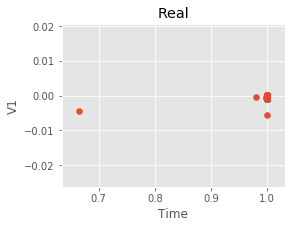

In [310]:
plt.figure(figsize=(4, 3))
plt.scatter(fraudes_norm.Time, fraudes_norm.V1)
plt.xlabel('Time')
plt.ylabel('V1')
plt.title('Real')

(0.65, 1.025)

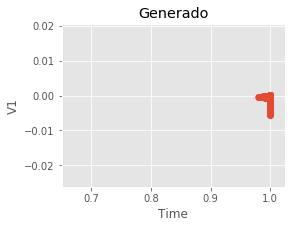

In [311]:
plt.figure(figsize=(4, 3))
plt.scatter(datos_generados_SMOTE[4][datos_generados_SMOTE[4].Class == 1].Time, datos_generados_SMOTE[4][datos_generados_SMOTE[4].Class == 1].V1)
plt.xlabel('Time')
plt.ylabel('V1')
plt.title('Generado')
plt.xlim(0.65, 1.025)

## 7. Impacto de datos sintéticos en los clasificadores

Ahora bien, ya creados nuestros datos nuevos con ambas técnicas, los añadimos a los datos de entrenamiento. Una vez hecho esto, entrenamos de nuevos los modelos originales para ver como estos nuevos datos hacen variar su desempeño.

### 7.1. Regresión Logística

#### 7.1.1. Utilizando datos generados por la GAN

In [251]:
modelos_GAN_rl = []
for data in train_GAN:
    w = {0:344, 1:(y_train.shape[0]-492)}
    m_lr = LogisticRegression(max_iter=10000, class_weight=w)
    m_lr.fit(data.drop('Class', axis = 1), data.Class)
    modelos_GAN_rl.append(m_lr)

#### 7.1.2. Utilizando datos generados por SMOTE

In [252]:
modelos_SMOTE_rl = []
for data in datos_generados_SMOTE:
    w = {0:344, 1:(y_train.shape[0]-492)}
    m_lr = LogisticRegression(max_iter=10000, class_weight=w)
    m_lr.fit(data.drop('Class', axis = 1), data.Class)
    modelos_SMOTE_rl.append(m_lr)

### 7.2. Random Forest
#### 7.2.1. Utilizando datos generados por la GAN

In [253]:
modelos_GAN_rf = []
for data in train_GAN:
    m_rf = RandomForestClassifier(class_weight={0:344,1:y_train.shape[0]-492})
    m_rf.fit(data.drop('Class', axis = 1), data.Class)
    modelos_GAN_rf.append(m_rf)

#### 7.2.2. Utilizando datos generados por SMOTE

In [254]:
modelos_SMOTE_rf = []
for data in datos_generados_SMOTE:
    m_rf = RandomForestClassifier(class_weight={0:344,1:y_train.shape[0]-492})
    m_rf.fit(data.drop('Class', axis = 1), data.Class)
    modelos_SMOTE_rf.append(m_rf)

### 7.3. Gradient Boosting
#### 7.3.1. Utilizando datos generados por la GAN

In [255]:
modelos_GAN_XGB = []
for data in train_GAN:
    dtrain = xgb.DMatrix(data.drop('Class', axis = 1), data.Class, feature_names = data.drop('Class', axis = 1).columns)
    results_dict = {}

    xgb_params = {
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'auc'
    }

    m1_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                         verbose_eval=False,
                         early_stopping_rounds=20, 
                         evals=[(dtrain,'train')],
                         evals_result = results_dict,              
                         feval = recall, maximize=True
                        )
    modelos_GAN_XGB.append(m1_xgb)

#### 7.3.2. Utilizando datos generados por SMOTE

In [256]:
modelos_SMOTE_XGB = []
for data in datos_generados_SMOTE:
    dtrain = xgb.DMatrix(data.drop('Class', axis = 1), data.Class, feature_names = data.drop('Class', axis = 1).columns)
    results_dict = {}

    xgb_params = {
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'auc'
    }

    m1_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                         verbose_eval=False,
                         early_stopping_rounds=20, 
                         evals=[(dtrain,'train')],
                         evals_result = results_dict,              
                         feval = recall, maximize=True
                        )
    modelos_SMOTE_XGB.append(m1_xgb)

## 8. Evaluación 

In [61]:
from sklearn.metrics import confusion_matrix
def especificidad(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

### 8.1. Regresión Logística

In [174]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [268]:
data_rl = {'Datos Generados':[0, 246, 492, 984, 4920, 29520],
        'Recall: GAN'   :[recall_score(y_test, m1_lr.predict(X_test_norm)), 
                         recall_score(y_test, modelos_GAN_rl[0].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rl[1].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rl[2].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rl[3].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rl[3].predict(X_test_norm)),
                        ],
        'Especificidad: GAN' :[especificidad(y_test, m1_lr.predict(X_test_norm)), 
                         especificidad(y_test, modelos_GAN_rl[0].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rl[1].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rl[2].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rl[3].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rl[4].predict(X_test_norm)),
                        ],
        'SMOTE Recall'   :[recall_score(y_test, m1_lr.predict(X_test_norm)), 
                         recall_score(y_test, modelos_SMOTE_rl[0].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rl[1].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rl[2].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rl[3].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rl[4].predict(X_test_norm)),
                        ],
        'Especificidad: SMOTE' :[especificidad(y_test, m1_lr.predict(X_test_norm)), 
                         especificidad(y_test, modelos_SMOTE_rl[0].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rl[1].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rl[2].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rl[3].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rl[4].predict(X_test_norm)),
                        ]}

df_eval_lr = pd.DataFrame(data_rl, index =['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5', 'Modelo 6'])
df_eval_lr

,Datos Generados,Recall: GAN,Especificidad: GAN,SMOTE Recall,Especificidad: SMOTE
Modelo 1,0,0.472973,0.999109,0.472973,0.999109
Modelo 2,246,0.513514,0.998511,0.722973,0.997526
Modelo 3,492,0.513514,0.997901,0.824324,0.989566
Modelo 4,984,0.520270,0.996823,0.993243,0.019696
Modelo 5,4920,0.554054,0.994384,0.993243,0.008875
Modelo 6,29520,0.554054,0.990726,0.993243,0.005065


### 8.2. Random Forest

In [261]:
X_test_norm = test_norm.drop('Class', axis = 1)

In [262]:
y_test.sum()

148

In [275]:
data_rf = {'Datos Generados':[0, 246, 492, 984, 4920, 29520],
        'Recall: GAN'   :[recall_score(y_test, m1_rf.predict(X_test_norm)), 
                         recall_score(y_test, modelos_GAN_rf[0].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rf[1].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rf[2].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rf[3].predict(X_test_norm)),
                         recall_score(y_test, modelos_GAN_rf[3].predict(X_test_norm)),
                        ],
        'Especificidad: GAN' :[especificidad(y_test, m1_rf.predict(X_test_norm)), 
                         especificidad(y_test, modelos_GAN_rf[0].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rf[1].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rf[2].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rf[3].predict(X_test_norm)),
                         especificidad(y_test, modelos_GAN_rf[4].predict(X_test_norm)),
                        ],
        'SMOTE Recall'   :[recall_score(y_test, m1_rf.predict(X_test_norm)), 
                         recall_score(y_test, modelos_SMOTE_rf[0].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rf[1].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rf[2].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rf[3].predict(X_test_norm)),
                         recall_score(y_test, modelos_SMOTE_rf[4].predict(X_test_norm)),
                        ],
        'Especificidad: SMOTE' :[especificidad(y_test, m1_rf.predict(X_test_norm)), 
                         especificidad(y_test, modelos_SMOTE_rf[0].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rf[1].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rf[2].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rf[3].predict(X_test_norm)),
                         especificidad(y_test, modelos_SMOTE_rf[4].predict(X_test_norm)),
                        ]}

df_eval_rf = pd.DataFrame(data_rf, index =['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5', 'Modelo 6'])
df_eval_rf

,Datos Generados,Recall: GAN,Especificidad: GAN,SMOTE Recall,Especificidad: SMOTE
Modelo 1,0,0.695946,0.999941,0.695946,0.999941
Modelo 2,246,0.682432,0.999941,0.743243,0.999906
Modelo 3,492,0.689189,0.999918,0.722973,0.999930
Modelo 4,984,0.709459,0.999930,0.756757,0.999918
Modelo 5,4920,0.695946,0.999894,0.763514,0.999906
Modelo 6,29520,0.695946,0.999918,0.770270,0.999848


### 8.3. Gradient Boosting

In [273]:
dtest = xgb.DMatrix(X_test_norm, y_test, feature_names = X_test_norm.columns)
data_xgb = {'Datos Generados':[0, 246, 492, 984, 4920, 29520],
        'Recall: GAN'   :[recall_score(y_test, np.round(m1_xgb.predict(dtest, ntree_limit =m1_xgb.best_iteration+1))), 
                         recall_score(y_test,  np.round(modelos_GAN_XGB[0].predict(dtest, ntree_limit = modelos_GAN_XGB[0].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_GAN_XGB[1].predict(dtest, ntree_limit = modelos_GAN_XGB[1].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_GAN_XGB[2].predict(dtest, ntree_limit = modelos_GAN_XGB[2].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_GAN_XGB[3].predict(dtest, ntree_limit = modelos_GAN_XGB[3].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_GAN_XGB[4].predict(dtest, ntree_limit = modelos_GAN_XGB[4].best_iteration+1))),
                        ],
        'Especificidad: GAN' :[especificidad(y_test, np.round(m1_xgb.predict(dtest, ntree_limit =m1_xgb.best_iteration+1))), 
                         especificidad(y_test,  np.round(modelos_GAN_XGB[0].predict(dtest, ntree_limit = modelos_GAN_XGB[0].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_GAN_XGB[1].predict(dtest, ntree_limit = modelos_GAN_XGB[1].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_GAN_XGB[2].predict(dtest, ntree_limit = modelos_GAN_XGB[2].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_GAN_XGB[3].predict(dtest, ntree_limit = modelos_GAN_XGB[3].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_GAN_XGB[4].predict(dtest, ntree_limit = modelos_GAN_XGB[4].best_iteration+1))),
                        ],
        'Recall: SMOTE'   :[recall_score(y_test, np.round(m1_xgb.predict(dtest, ntree_limit =m1_xgb.best_iteration+1))), 
                         recall_score(y_test,  np.round(modelos_SMOTE_XGB[0].predict(dtest, ntree_limit = modelos_SMOTE_XGB[0].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_SMOTE_XGB[1].predict(dtest, ntree_limit = modelos_SMOTE_XGB[1].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_SMOTE_XGB[2].predict(dtest, ntree_limit = modelos_SMOTE_XGB[2].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_SMOTE_XGB[3].predict(dtest, ntree_limit = modelos_SMOTE_XGB[3].best_iteration+1))),
                         recall_score(y_test,  np.round(modelos_SMOTE_XGB[4].predict(dtest, ntree_limit = modelos_SMOTE_XGB[4].best_iteration+1))),
                        ],
        'Especificidad: SMOTE' :[especificidad(y_test, np.round(m1_xgb.predict(dtest, ntree_limit =m1_xgb.best_iteration+1))), 
                         especificidad(y_test,  np.round(modelos_SMOTE_XGB[0].predict(dtest, ntree_limit = modelos_SMOTE_XGB[0].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_SMOTE_XGB[1].predict(dtest, ntree_limit = modelos_SMOTE_XGB[1].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_SMOTE_XGB[2].predict(dtest, ntree_limit = modelos_SMOTE_XGB[2].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_SMOTE_XGB[3].predict(dtest, ntree_limit = modelos_SMOTE_XGB[3].best_iteration+1))),
                         especificidad(y_test,  np.round(modelos_SMOTE_XGB[4].predict(dtest, ntree_limit = modelos_SMOTE_XGB[3].best_iteration+1))),
                        ]}

df_eval_xgb = pd.DataFrame(data_xgb, index =['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5', 'Modelo 6'])
df_eval_xgb

,Datos Generados,Recall: GAN,Especificidad: GAN,Recall: SMOTE,Especificidad: SMOTE
Modelo 1,0,0.810811,0.997198,0.810811,0.997198
Modelo 2,246,0.513514,0.999871,0.682432,0.999836
Modelo 3,492,0.513514,0.999859,0.662162,0.999848
Modelo 4,984,0.540541,0.999730,0.770270,0.999660
Modelo 5,4920,0.500000,0.999695,0.790541,0.999484
Modelo 6,29520,0.500000,0.999801,0.810811,0.998452


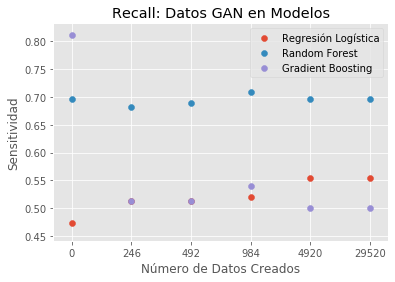

In [313]:
datos_x = ['0', '246', '492', '984', '4920', '29520']
plt.scatter(datos_x, df_eval_lr['Recall: GAN'], label = 'Regresión Logística')
plt.scatter(datos_x, df_eval_rf['Recall: GAN'], label = 'Random Forest')
plt.scatter(datos_x, df_eval_xgb['Recall: GAN'], label = 'Gradient Boosting')
plt.xlabel('Número de Datos Creados')
plt.ylabel('Sensitividad')
plt.title('Recall: Datos GAN en Modelos')
plt.legend(loc="upper right")

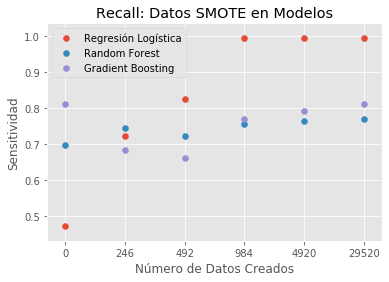

In [288]:
datos_x = ['0', '246', '492', '984', '4920', '29520']
plt.scatter(datos_x, df_eval_lr['SMOTE Recall'], label = 'Regresión Logística')
plt.scatter(datos_x, df_eval_rf['SMOTE Recall'], label = 'Random Forest')
plt.scatter(datos_x, df_eval_xgb['Recall: SMOTE'], label = 'Gradient Boosting')
plt.xlabel('Número de Datos Creados')
plt.ylabel('Sensitividad')
plt.title('Recall: Datos SMOTE en Modelos')
plt.legend(loc="upper left")

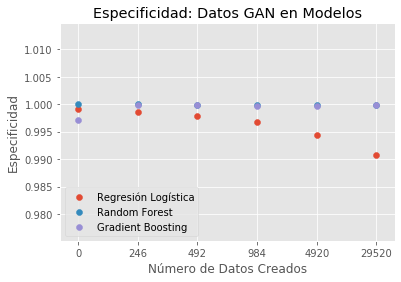

In [289]:
datos_x = ['0', '246', '492', '984', '4920', '29520']
plt.scatter(datos_x, df_eval_lr['Especificidad: GAN'], label = 'Regresión Logística')
plt.scatter(datos_x, df_eval_rf['Especificidad: GAN'], label = 'Random Forest')
plt.scatter(datos_x, df_eval_xgb['Especificidad: GAN'], label = 'Gradient Boosting')
plt.xlabel('Número de Datos Creados')
plt.ylabel('Especificidad')
plt.title('Especificidad: Datos GAN en Modelos')
plt.legend(loc="lower left")

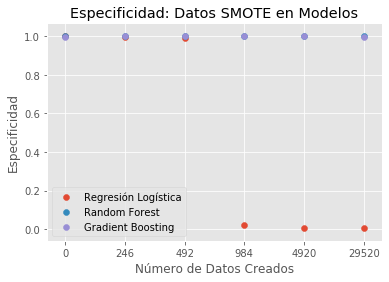

In [290]:
datos_x = ['0', '246', '492', '984', '4920', '29520']
plt.scatter(datos_x, df_eval_lr['Especificidad: SMOTE'], label = 'Regresión Logística')
plt.scatter(datos_x, df_eval_rf['Especificidad: SMOTE'], label = 'Random Forest')
plt.scatter(datos_x, df_eval_xgb['Especificidad: SMOTE'], label = 'Gradient Boosting')
plt.xlabel('Número de Datos Creados')
plt.ylabel('Especificidad')
plt.title('Especificidad: Datos SMOTE en Modelos')
plt.legend(loc="lower left")

## 9. Nuevo Approach: SVM de una sola clase

In [8]:
from sklearn.svm import OneClassSVM 
X_train_normal   = train_norm[train_norm['Class'] == 0].drop('Class', axis = 1)
y_train_normal   = train_norm[train_norm['Class'] == 0].Class

X_train_todo     = train_norm.drop('Class', axis = 1)
y_train_todo     = train_norm.Class
y_train_todo     = y_train_todo.apply(lambda x: -1 if x==1  else (1 if x==0 else 1))

X_train_outliers = train_norm[train_norm['Class'] == 1].drop('Class', axis = 1)
y_train_outliers = train_norm[train_norm['Class'] == 1].Class
X_test_todo      = test_norm.drop(['Class'], axis = 1)
y_test_todo      = test_norm.Class
y_test_todo      = y_test_todo.apply(lambda x: -1 if x==1  else (1 if x==0 else 1))

In [9]:
y_test_todo.value_counts()

 1    85295
-1      148
Name: Class, dtype: int64

In [10]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import make_scorer
def sensitivity_score(y_true, y_pred):
    return recall_score(y_true,y_pred, pos_label=-1)
sensitivity_scorer = make_scorer(sensitivity_score, greater_is_better=True)

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import sklearn
outlier_prop = len(y_train_outliers)/len(y_train_todo)
param_grid = {'nu':[0.00001, 0.0001, 0.001, 0.01],
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf', 'sigmoid']} 
oc_svm = GridSearchCV(OneClassSVM(),param_grid,refit=True,verbose=2, scoring = sensitivity_scorer)#sensitivity_scorer)
oc_svm.fit(X_train_todo,y_train_todo)
y_pred_todo = oc_svm.predict(X_test_todo)
confusion_matrix(y_test_todo , y_pred_todo )

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] gamma=1, kernel=rbf, nu=1e-05 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... gamma=1, kernel=rbf, nu=1e-05, total=   0.3s
[CV] gamma=1, kernel=rbf, nu=1e-05 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................... gamma=1, kernel=rbf, nu=1e-05, total=   0.3s
[CV] gamma=1, kernel=rbf, nu=1e-05 ...................................
[CV] .................... gamma=1, kernel=rbf, nu=1e-05, total=   0.2s
[CV] gamma=1, kernel=rbf, nu=1e-05 ...................................
[CV] .................... gamma=1, kernel=rbf, nu=1e-05, total=   0.2s
[CV] gamma=1, kernel=rbf, nu=1e-05 ...................................
[CV] .................... gamma=1, kernel=rbf, nu=1e-05, total=   0.2s
[CV] gamma=1, kernel=rbf, nu=0.0001 ..................................
[CV] ................... gamma=1, kernel=rbf, nu=0.0001, total=   0.5s
[CV] gamma=1, kernel=rbf, nu=0.0001 ..................................
[CV] ................... gamma=1, kernel=rbf, nu=0.0001, total=   0.5s
[CV] gamma=1, kernel=rbf, nu=0.0001 ..................................
[CV] ................... gamma=1, kernel=rbf, nu=0.0001, total=   0.4s
[CV] gamma=1, kernel=rbf, nu=0.0001 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 69.4min finished


array([[   56,    92],
       [18757, 66538]], dtype=int64)

Sensitividad:

In [16]:
recall_score(y_test_todo , y_pred_todo,pos_label=-1)

0.3783783783783784

Recall:

In [17]:
recall_score(y_test_todo , y_pred_todo)

0.78009261973152

## 10. Cost Sensitive Classification

Importamos *costcla*, librería utilizada para este tipo de clasificación. Es necesario crear un ambiente virtual de Conda con python 3.5 o python 2.7 para que permita utilizarla.

In [115]:
from costcla.models import CostSensitiveLogisticRegression
from costcla.models import CostSensitiveRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from costcla.metrics import binary_classification_metrics

Definimos la matriz de costos de la siguiente forma:

[costo de falsos positivos, costo de falsos negativos; costo verdaderos positivos; costo verderos negativos]

En este caso el costo es el valor de la transacción:


**cost_mat_train --> [5%*costo; costo; 0; 0]**

**cost_mat_test  --> [5%*costo; costo; 0; 0]**

In [133]:
tasa = 0.05
tasa_train = np.full((len(X_train_norm),), tasa)
mat_costos_train = np.transpose(np.array([X_train_norm[:, 29]*tasa_train, X_train_norm[:, 29], 
                            np.full((len(X_train_norm),), 0), np.full((len(X_train_norm),), 0)]))

tasa_test = np.full((len(X_test_norm),), tasa)
mat_costos_test = np.transpose(np.array([X_test_norm[:, 29]*tasa_test, X_test_norm[:, 29], 
                            np.full((len(X_test_norm),), 0), np.full((len(X_test_norm),), 0)]))

In [134]:
import warnings
warnings.filterwarnings('ignore')
#Regresión logística sensible al costo
cs_lr = CostSensitiveLogisticRegression()
cs_lr.fit(X_train_norm, y_train, mat_costos_train)
y_pred_test_cs_lr = cs_lr.predict(X_test_norm)

#Regresión logística sin sensibilidad al costo
lr = LogisticRegression()
lr.fit(X_train_norm, y_train)
y_pred_test_lr = lr.predict(X_test_norm)

In [130]:
print(savings_score(y_test, y_pred_test_cs_lr, mat_costos_test))

print(savings_score(y_test, y_pred_test_lr, mat_costos_test))

-0.07238332988636831
0.0


In [131]:
binary_classification_metrics(y_test, y_pred_test_cs_lr, cs_lr.predict_proba(X_test_norm)[:,1])

{'accuracy': 0.9982561473731025,
 'auc': 0.49999413799167597,
 'brier_loss': 0.2284797567029846,
 'f1score': 0,
 'fn': 148.0,
 'fp': 1.0,
 'precision': 0.0,
 'recall': 0.0,
 'tn': 85294.0,
 'tp': 0.0}

In [132]:
binary_classification_metrics(y_test, y_pred_test_lr, lr.predict_proba(X_test_norm)[:,1])

{'accuracy': 0.9982678510820079,
 'auc': 0.5,
 'brier_loss': 0.0017291469845417521,
 'f1score': 0,
 'fn': 148.0,
 'fp': 0.0,
 'precision': 0,
 'recall': 0.0,
 'tn': 85295.0,
 'tp': 0.0}

In [135]:
import warnings
warnings.filterwarnings('ignore')
#Random Forest sensible al costo
cs_rf = CostSensitiveRandomForestClassifier()
cs_rf.fit(X_train_norm, y_train, mat_costos_train)
y_pred_test_cs_rf = cs_rf.predict(X_test_norm)

#Random Forest sin sensibilidad al costo
rf = RandomForestClassifier()
rf.fit(X_train_norm, y_train)
y_pred_test_rf = rf.predict(X_test_norm)

In [122]:
binary_classification_metrics(y_test, y_pred_test_cs_rf, cs_rf.predict_proba(X_test_norm)[:,1])

{'accuracy': 0.9987711105649381,
 'auc': 0.6655053684905964,
 'brier_loss': 0.0010323160951031122,
 'f1score': 0.48275862068965514,
 'fn': 99.0,
 'fp': 6.0,
 'precision': 0.8909090909090909,
 'recall': 0.3310810810810811,
 'tn': 85289.0,
 'tp': 49.0}

In [123]:
binary_classification_metrics(y_test, y_pred_test_rf, rf.predict_proba(X_test_norm)[:,1])

{'accuracy': 0.9994850368081645,
 'auc': 0.868213933201623,
 'brier_loss': 0.0005097082265369895,
 'f1score': 0.8320610687022901,
 'fn': 39.0,
 'fp': 5.0,
 'precision': 0.956140350877193,
 'recall': 0.7364864864864865,
 'tn': 85290.0,
 'tp': 109.0}